In [1]:
from classes.Navigation import Navigation

navigation = Navigation('2_1_prepare_data.ipynb')

navigation.display_header()

[Главная](./1_main.ipynb) &raquo; Первичная обработка данных

# Первичная обработка данных

## Оглавление

- [Загрузка данных](#item_load)
- [Разделение таблицы на две (`data_newbies` и `data_participated`)](#item_split)
- [Обработка данных для таблиц `data_newbies` и `data_participated`](#item_prepare)
- [Результат обработки данных для таблицы `data_newbies`](#item_result_newbies)
- [Результат обработки данных для таблицы `data_participated`](#item_result_participated)

## Загрузка данных <a id="item_load"></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from classes.PrepareDataNewbies import PrepareDataNewbies
from classes.PrepareDataParticipated import PrepareDataParticipated
from functions.graphics import (
    show_pie, 
    show_countplot_by_target,
)
from functions.display_content import (
    display_field_description, 
    display_field_descriptions,
    display_fields_info, 
    display_fields_distribution,
)

In [3]:
# Загрузим данные
data_source = pd.read_csv('./data/bank_fin.csv', sep=';')

# Сделаем копию таблицы
data = data_source.copy()

# Выведем первые строки
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


Признак `balance` имеет строковое представление, \
далее для перевода его в числовой используется функция `get_balance`\
из [function.prepare_data](./functions//prepare_data.py).

<h2>Разделение таблицы на две <br /> (<code>data_newbies</code> и <code>data_participated</code>) <a id="item_split"></a></h2>

Исследование показывает, что значения полей, \
которые содержат информацию об участии в предыдущих кампаниях банка:

In [4]:
display_field_descriptions(['pdays', 'previous', 'poutcome'])

- `pdays` - количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании

- `previous` - количество контактов до текущей кампании

- `poutcome` - результат прошлой маркетинговой кампании

не информативны для клиентов, которые в них не участвовали.

Поэтому разделим исходную таблицу на две.
- `data_newbies` - клиенты, не участвовавшие ранее в кампаниях банка,
- `data_participated` - клиенты, участвовавшие ранее в кампаниях банка.

**Прежде чем разделить таблицы, посмотрим на соотношения данных в них**

Сделаем временный признак `is_newbies`, который будет содержать флаг, \
участвовал клиент в прошлых кампаниях или нет.

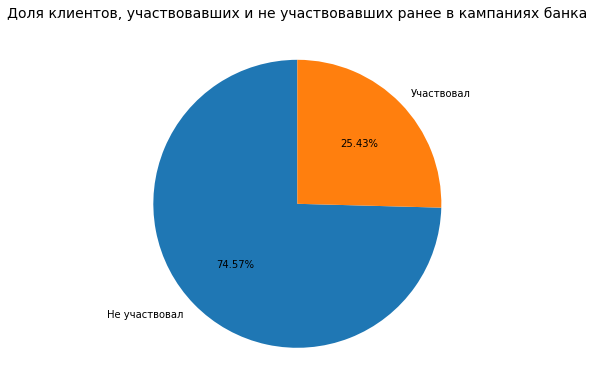

In [4]:
# В признаке previous содержится количество контактов до текущей кампании.
# Если оно равно 0, значит текущая кампания для клиента первая.
data['is_newbies'] = data['previous']\
    .apply(lambda x: 'Не участвовал' if x == 0 else 'Участвовал')

# Выведем круговую диаграмму с долями клиентов двух типов
show_pie(
    data, 
    'is_newbies', 
    'Доля клиентов, участвовавших и не участвовавших ранее в кампаниях банка'
)

Почти 75% клиентов не участвовали ранее в кампаниях банка.\
Посмотрим, кто чаще открывает депозит.

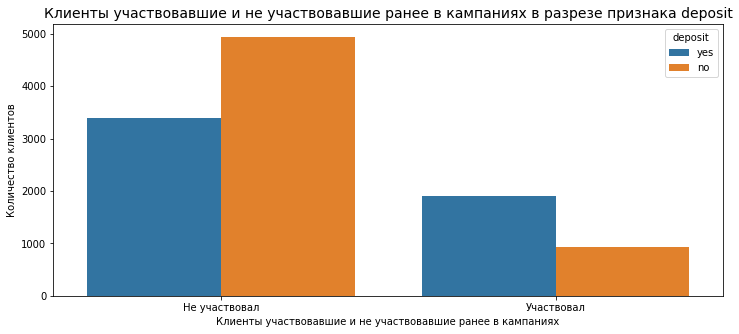

In [5]:
# Построим столбчатую диаграмму
show_countplot_by_target(
    data, 
    'is_newbies', 
    'Клиенты участвовавшие и не участвовавшие ранее в кампаниях в разрезе признака deposit', 
    'Клиенты участвовавшие и не участвовавшие ранее в кампаниях', 
    figsize=(12, 5),
    should_sort=False,
)

- Клиенты, участвовавшие в кампаниях, в большинстве открыли депозит.
- Клиенты, не участвовавшие в кампаниях, в большинстве отказываются от открытия депозита.

**Теперь разделим таблицу на две части**

In [6]:
# Удалим временный столбец, он нам не пригодится
data.drop(columns=['is_newbies'], inplace=True)

# Таблица с клиентами, не участвовавшими ранее в кампаниях банка
mask_not_newbies = data['previous'] > 0
data_newbies = data.drop(index=data[mask_not_newbies].index, axis=0)

# Таблица с клиентами, участвовавшими ранее в кампаниях банка
mask_not_participated = data['previous'] == 0
data_participated = data.drop(index=data[mask_not_participated].index, axis=0)

**Посмотрим, что содержиться в столбцах `pdays`, `previous`, `poutcome` у таблицы `data_newbies`**

In [7]:
display_field_description('pdays')

- `pdays` - количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании

In [8]:
data_newbies['pdays'].value_counts()

-1    8324
Name: pdays, dtype: int64

Все значения равны `-1`, потому что контактов не было.\
Ниже удалим этот столбец.

In [9]:
display_field_description('previous')

- `previous` - количество контактов до текущей кампании

In [10]:
data_newbies['previous'].value_counts()

0    8324
Name: previous, dtype: int64

Все значения равны `0`, так как контактов не было.\
Ниже удалим этот столбец.

In [11]:
display_field_description('poutcome')

- `poutcome` - результат прошлой маркетинговой кампании

In [12]:
data_newbies['poutcome'].value_counts()

unknown    8324
Name: poutcome, dtype: int64

Результат прошлых кампаний неизвестен (их не было), также удалим этот столбец.

In [13]:
# Удаляем столбцы
data_newbies.drop(columns=['pdays', 'previous', 'poutcome'], inplace=True)

Операции для формирования таблиц `data_newbies` и `data_participated` \
вынесены в метод `set_specific_data` классов  `PrepareDataNewbies` и `PrepareDataParticipated` соответственно\
(для дальнейшего использования).

<h2>Обработка данных для таблиц<br /> <code>data_newbies</code> и <code>data_participated</code> <a id="item_prepare"></a></h2>

**Далее рассмотрим обе таблицы отдельно.**

- Исследование данных таблицы `data_newbies` на пропуски и выбросы \
вынесено в файл [2_2_prepare_data_newbies.ipynb](./2_2_prepare_data_newbies.ipynb).

- Исследование данных таблицы `data_participated` на пропуски и выбросы \
вынесено в файл [2_2_prepare_data_participated.ipynb](./2_2_prepare_data_participated.ipynb).

Знакомство с данными показывает, что **для обеих таблиц**:

- Признак `balance` имеет пропуски и выбросы.\
Пропуски заполним **медианой**, а выбросы удалим по методу **Тьюки**.
- Признак `job` имеет пропуски, заполненные значением `unknown`.\
Заполним их модой `management`.
- Признак `education` имеет пропуски, заполненные значением `unknown`.\
Заполним их модой `secondary`.
- Признаки `deposit`, `default`, `housing`, `loan` переведем в бинарные \
(`yes` будет соответствовать `1`, `no` - `0`).
- Числовые признаки `age`, `duration`, `campaign` находятся в рамках правдоподобных.\
Пока не будем их менять.

**Для таблицы `data_newbies`**:
- Для признака `contact` доля неизвестных значений, помеченных `unknown` довольно большая.\
Оставим пока эти значение без изменений.

**Для таблицы `data_participated`**:

- Признак `contact`  имеет пропуски, обозначенные `unknown`.\
Заполним их модой `cellular`.
- Признак `poutcome` также имеет пропуски, обозначенные `unknown`.\
Заполним их значением `other`.
- Значения признаков `pdays` и `previous` находятся в рамках правдоподобных. \
Не будем их менять.

Выполнение описанных преобразований вынесено в метод `specific_prepare_data` \
классов `PrepareDataNewbies` и `PrepareDataParticipated`\
(также для дальнейшего использования).

Воспользуемся созданным методом и посмотрим на полученные таблицы.

## Результат обработки данных для таблицы `data_newbies` <a id="item_result_newbies"></a>

In [14]:
# Получим обработанные данные таблицы data_newbies
prepareDataNewbies = PrepareDataNewbies(data_source)

prepareDataNewbies.specific_prepare_data()

prepared_data_newbies = prepareDataNewbies.get_data()

**Посмотрим на информацию о столбцах после обработки данных.**

In [15]:
# Посмотрим на информацию о столбцах
display_fields_info(prepared_data_newbies)

**Выведем первые строки таблицы**

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,deposit
0,59,admin.,married,secondary,0,2343.0,1,0,unknown,5,may,1042,1,1
1,56,admin.,married,secondary,0,45.0,0,0,unknown,5,may,1467,1,1
2,41,technician,married,secondary,0,1270.0,1,0,unknown,5,may,1389,1,1
3,55,services,married,secondary,0,2476.0,1,0,unknown,5,may,579,1,1
4,54,admin.,married,tertiary,0,184.0,0,0,unknown,5,may,673,2,1


**Размер таблицы**

(7499, 14)

**Информация о столбцах**

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7499 entries, 0 to 11161
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        7499 non-null   int64  
 1   job        7499 non-null   object 
 2   marital    7499 non-null   object 
 3   education  7499 non-null   object 
 4   default    7499 non-null   int64  
 5   balance    7499 non-null   float64
 6   housing    7499 non-null   int64  
 7   loan       7499 non-null   int64  
 8   contact    7499 non-null   object 
 9   day        7499 non-null   int64  
 10  month      7499 non-null   object 
 11  duration   7499 non-null   int64  
 12  campaign   7499 non-null   int64  
 13  deposit    7499 non-null   int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 878.8+ KB


None

**Количество пропусков в столбцах**

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
deposit      0
dtype: int64

> Убрали пропуски и перевели бинарные признаки в числовой вид.

**Посмотрим на распределение баланса после удаления выбросов.**

### Признак `balance` (баланс)

Посмотрим на распределение признака `balance`

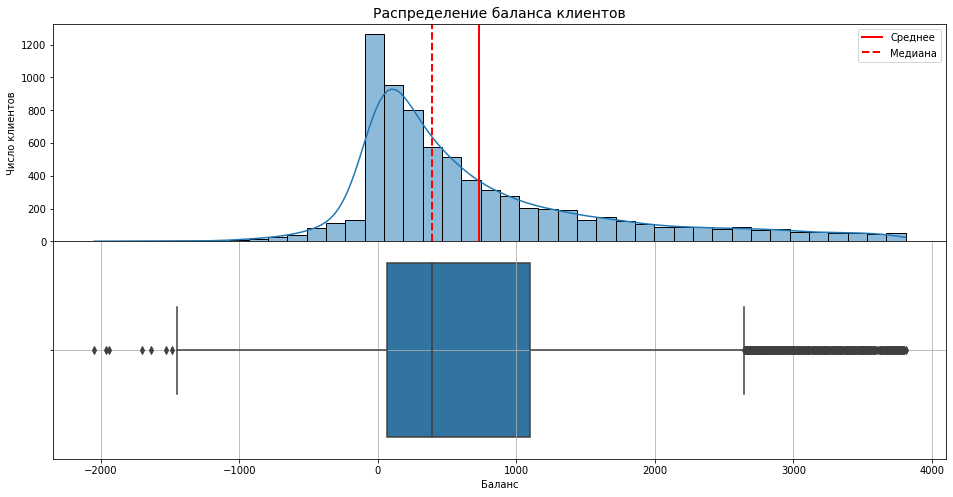

**Числовые характерстики распределения значений признака `balance`**

,Характеристика,Значение
0,count,7499.000000
1,mean,728.866782
2,std,936.149469
3,min,-2049.000000
4,25%,67.000000
5,50%,392.000000
6,75%,1098.500000
7,max,3810.000000


In [16]:
display_fields_distribution(pd.DataFrame(prepared_data_newbies['balance']))

> Распределение не является нормальным. Но выбросов стало меньше.

## Результат обработки данных для таблицы `data_participated` <a id="item_result_participated"></a>

In [17]:
# Получим обработанные данные таблицы data_participated
prepareDataParticipated = PrepareDataParticipated(data_source)

prepareDataParticipated.specific_prepare_data()

prepared_data_participated = prepareDataParticipated.get_data()

**Посмотрим на информацию о столбцах после обработки данных.**

In [18]:
# Посмотрим на информацию о столбцах
display_fields_info(prepared_data_participated)

**Выведем первые строки таблицы**

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
890,42,admin.,single,secondary,0,-247.0,1,1,telephone,21,oct,519,1,166,1,other,1
891,33,services,married,secondary,0,3444.0,1,0,telephone,21,oct,144,1,91,4,failure,1
899,56,technician,married,secondary,0,589.0,1,0,cellular,23,oct,518,1,147,2,success,1
933,34,admin.,married,tertiary,0,899.0,1,0,cellular,12,nov,114,1,170,3,failure,1
951,53,retired,married,tertiary,0,2269.0,0,0,cellular,17,nov,1091,2,150,1,success,1


**Размер таблицы**

(2594, 17)

**Информация о столбцах**

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2594 entries, 890 to 11160
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        2594 non-null   int64  
 1   job        2594 non-null   object 
 2   marital    2594 non-null   object 
 3   education  2594 non-null   object 
 4   default    2594 non-null   int64  
 5   balance    2594 non-null   float64
 6   housing    2594 non-null   int64  
 7   loan       2594 non-null   int64  
 8   contact    2594 non-null   object 
 9   day        2594 non-null   int64  
 10  month      2594 non-null   object 
 11  duration   2594 non-null   int64  
 12  campaign   2594 non-null   int64  
 13  pdays      2594 non-null   int64  
 14  previous   2594 non-null   int64  
 15  poutcome   2594 non-null   object 
 16  deposit    2594 non-null   int64  
dtypes: float64(1), int64(10), object(6)
memory usage: 364.8+ KB


None

**Количество пропусков в столбцах**

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

> Также убрали пропуски и перевели бинарные признаки в числовой вид.

**И здесь посмотрим на распределение баланса после удаления выбросов.**

### Признак `balance` (баланс)

Посмотрим на распределение признака `balance`

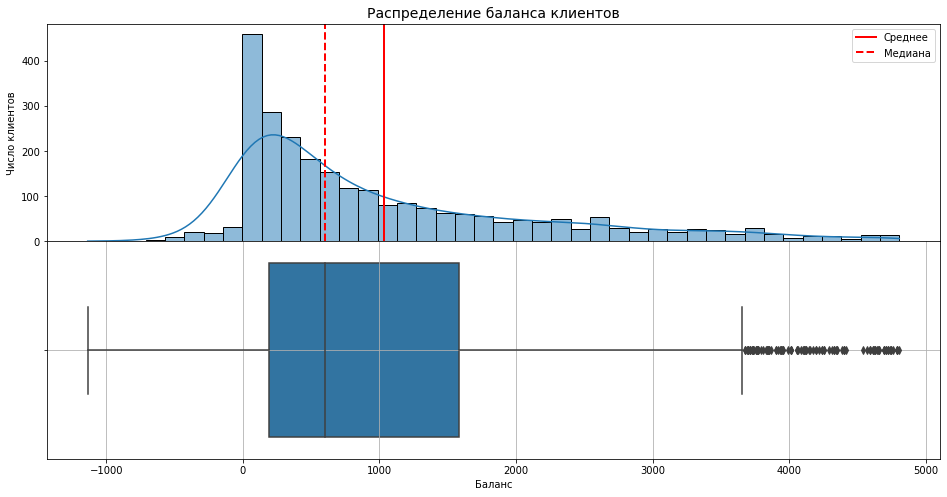

**Числовые характерстики распределения значений признака `balance`**

,Характеристика,Значение
0,count,2594.000000
1,mean,1032.380879
2,std,1132.776906
3,min,-1137.000000
4,25%,190.250000
5,50%,604.000000
6,75%,1579.000000
7,max,4807.000000


In [19]:
display_fields_distribution(pd.DataFrame(prepared_data_participated['balance']))

> Также распределение не является нормальным. И выбросов стало меньше.

In [2]:
navigation.display_backlink()

**Вернуться к файлу &laquo;[Главная](./1_main.ipynb)&raquo;**